# Introduction & Installation

For consistent usage of the dataset, releases have tags in the GitHub and HuggingFace repos. A stable, first version is tagged by `v1.0`, cf. `@v1.0` in  `pip install` below. The tag is consistently reused in `revision` options of the HuggingFace `datasets.load_dataset()` method and to instantiate the TorchGeo class `ssl4eo_eu_forest.SSL4EOEUForestTG()`.

In [1]:
!pip install -q git+https://github.com/cmalbrec/ssl4eo_eu_forest.git@v1.0

In [2]:
SSL4EO_EU_FOREST_REVISION = 'v1.0'

# Explore the SSL4EO-EU-Forest data

In [3]:
# disable link warnings for folks on Windows machines
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

In [5]:
# reset HuggingFace cache for dataset
from datasets import config
import shutil

# Target dataset name
dataset_name = 'ssl4eo_eu_forest'

# Get the base cache directory
base_cache_dir = config.HF_DATASETS_CACHE / '..' 

# Walk through the cache and delete matching folders
for root, dirs, files in os.walk(base_cache_dir):
    for d in dirs:
        if dataset_name in d:
            full_path = os.path.join(root, d)
            print(f"Deleting: {full_path}")
            shutil.rmtree(full_path)

## Inspect metadata

In [6]:
# natively load HuggingFace metadata into Pandas dataframe
import datasets
import pandas as pd

df_ssl4eo_eu_forest = pd.DataFrame(
    [
        line
        for line in datasets.load_dataset(
            "dm4eo/ssl4eo_eu_forest",
            trust_remote_code=True,
            streaming=True,
            revision=SSL4EO_EU_FOREST_REVISION,
        )["train"]
    ]
)

df_ssl4eo_eu_forest

README.md: 0.00B [00:00, ?B/s]

ssl4eo_eu_forest.py: 0.00B [00:00, ?B/s]

,group_id,mask_path,bbox_epsg4326,mask_width,mask_height,dimensions_match,images
0,0000040,masks/0000040/mask.tif,"[12.967036279725626, 61.924340161746514, 13.01...",264,264,True,{'path': ['images/0000040/20180204T103221_2018...
1,0000019,masks/0000019/mask.tif,"[18.67733635492509, 63.3360058488168, 18.73193...",264,264,True,{'path': ['images/0000019/20180221T102031_2018...
2,0000023,masks/0000023/mask.tif,"[13.065745294386039, 46.90732488334919, 13.101...",264,264,True,{'path': ['images/0000023/20180131T100229_2018...
3,0000026,masks/0000026/mask.tif,"[31.309692275210214, 37.134775831797356, 31.33...",264,264,True,{'path': ['images/0000026/20180206T084129_2018...
4,0000043,masks/0000043/mask.tif,"[25.872424436090903, 63.151436302023065, 25.92...",264,264,True,{'path': ['images/0000043/20180227T095019_2018...
...,...,...,...,...,...,...,...
17679,0039641,masks/0039641/mask.tif,"[-3.1667131165244764, 43.06016926465369, -3.13...",264,264,True,{'path': ['images/0039641/20180129T110309_2018...
17680,0039651,masks/0039651/mask.tif,"[22.817674490111997, 39.78293717499284, 22.849...",264,264,True,{'path': ['images/0039651/20180119T092309_2018...
17681,0039653,masks/0039653/mask.tif,"[22.32499367896818, 38.69884849185133, 22.3557...",264,264,True,{'path': ['images/0039653/20180208T092129_2018...
17682,0039642,masks/0039642/mask.tif,"[-3.215858451621129, 43.096197084992134, -3.18...",264,264,True,{'path': ['images/0039642/20180129T110309_2018...


In [7]:
!pip install -q contextily matplotlib

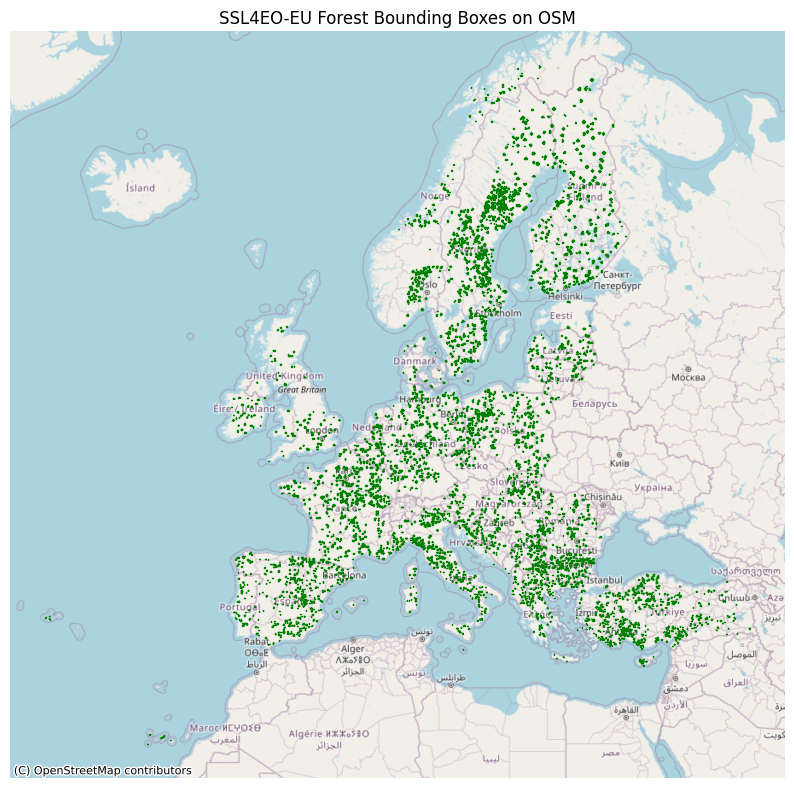

In [8]:
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import contextily as ctx

# Convert bounding boxes to geometries
df_ssl4eo_eu_forest['geometry'] = df_ssl4eo_eu_forest.bbox_epsg4326.apply(
    lambda b: shapely.geometry.box(b[0], b[1], b[2], b[3])
)

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_ssl4eo_eu_forest.drop(columns=["bbox_epsg4326"]),
    geometry="geometry",
    crs="EPSG:4326",
)

# Reproject to Web Mercator (required for OSM tiles)
gdf = gdf.to_crs(epsg=3857)

# Plot with OSM background
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, edgecolor="green", facecolor="none", linewidth=1,)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("SSL4EO-EU Forest Bounding Boxes on OSM")
plt.axis("off");

## Inspect data

In [9]:
# load SSL4EO-EU-Forest as TorchGeo dataset (with local "./cache" directory)
from ssl4eo_eu_forest import SSL4EOEUForestTG
dataset = SSL4EOEUForestTG(root="./cache", revision=SSL4EO_EU_FOREST_REVISION)

[INFO] Loading SSL4EO-EU Forest dataset from Hugging Face: dm4eo/ssl4eo_eu_forest@v1.0
[INFO] Dataset initialized with 17684 samples


In [10]:
# display a random sample (triggers a download to local disk cache)
import random

N = random.randint(0, len(dataset))
# 1st index for up to four seasons, 2nd for Sentinel-2 bands, index 3 and 4 spatial dimensions
dataset[N]['image'].shape

[DEBUG] Downloading mask for group 0006487 from https://huggingface.co/datasets/dm4eo/ssl4eo_eu_forest/resolve/main/masks/0006487/mask.tif
[DEBUG] Loaded mask shape: torch.Size([1, 264, 264]), dtype: byte
[DEBUG] Downloading winter image for group 0006487 from https://huggingface.co/datasets/dm4eo/ssl4eo_eu_forest/resolve/main/images/0006487/20180206T102209_20180206T102206_T32UPC/all_bands.tif
[DEBUG] Loaded winter image shape: torch.Size([12, 264, 264]), dtype: uint16
[DEBUG] Using cached winter image for group 0006487
[DEBUG] Loaded winter image shape: torch.Size([12, 264, 264]), dtype: uint16
[DEBUG] Downloading summer image for group 0006487 from https://huggingface.co/datasets/dm4eo/ssl4eo_eu_forest/resolve/main/images/0006487/20180701T102021_20180701T102404_T32UPC/all_bands.tif
[DEBUG] Loaded summer image shape: torch.Size([12, 264, 264]), dtype: uint16
[DEBUG] Downloading fall image for group 0006487 from https://huggingface.co/datasets/dm4eo/ssl4eo_eu_forest/resolve/main/images

torch.Size([4, 12, 264, 264])

In [11]:
# reloading picks the local cache
dataset[N]['mask']

[DEBUG] Using cached mask for group 0006487
[DEBUG] Loaded mask shape: torch.Size([1, 264, 264]), dtype: byte
[DEBUG] Using cached winter image for group 0006487
[DEBUG] Loaded winter image shape: torch.Size([12, 264, 264]), dtype: uint16
[DEBUG] Using cached winter image for group 0006487
[DEBUG] Loaded winter image shape: torch.Size([12, 264, 264]), dtype: uint16
[DEBUG] Using cached summer image for group 0006487
[DEBUG] Loaded summer image shape: torch.Size([12, 264, 264]), dtype: uint16
[DEBUG] Using cached fall image for group 0006487
[DEBUG] Loaded fall image shape: torch.Size([12, 264, 264]), dtype: uint16
[DEBUG] Final image shape (seasonal stack): torch.Size([4, 12, 264, 264])


tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]], dtype=torch.uint8)

In [12]:
# ... and we have metadata (after we disabled debug logging)
import logging
logging.getLogger("SSL4EOEUForestTG").setLevel(logging.INFO)

dataset[N]['metadata']

[{'season': 'winter',
  'timestamp_start': '20180206T102209',
  'timestamp_end': '20180206T102206',
  'tile_id': 'T32UPC',
  'shape': torch.Size([12, 264, 264]),
  'crs': 'EPSG:32632',
  'transform': Affine(10.0, 0.0, 623940.0,
         0.0, -10.0, 5746470.0)},
 {'season': 'winter',
  'timestamp_start': '20180301T103019',
  'timestamp_end': '20180301T103013',
  'tile_id': 'T32UPC',
  'shape': torch.Size([12, 264, 264]),
  'crs': 'EPSG:32632',
  'transform': Affine(10.0, 0.0, 623940.0,
         0.0, -10.0, 5746470.0)},
 {'season': 'summer',
  'timestamp_start': '20180701T102021',
  'timestamp_end': '20180701T102404',
  'tile_id': 'T32UPC',
  'shape': torch.Size([12, 264, 264]),
  'crs': 'EPSG:32632',
  'transform': Affine(10.0, 0.0, 623940.0,
         0.0, -10.0, 5746470.0)},
 {'season': 'fall',
  'timestamp_start': '20181017T103019',
  'timestamp_end': '20181017T103202',
  'tile_id': 'T32UPC',
  'shape': torch.Size([12, 264, 264]),
  'crs': 'EPSG:32632',
  'transform': Affine(10.0, 0.0

This is winter.


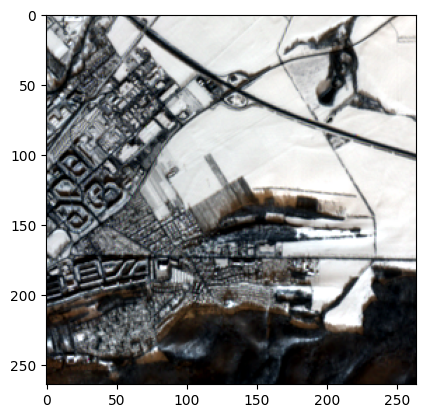

In [13]:
from matplotlib import pyplot as plt

# visualize a season
season_name = dataset[N]['metadata'][0]['season']
plt.imshow(dataset.rgb_from_samples(N)[season_name])
print(f'This is {season_name}.')

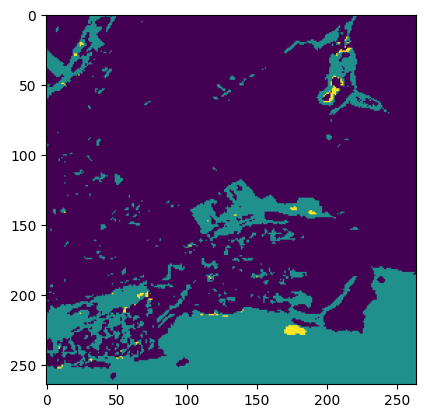

In [14]:
# plot the corresponding forest mask
plt.imshow(dataset.rgb_from_samples(N)['mask'])

In [15]:
# Where on Earth is this using interactive folium map (probably not working in GitHub preview)?
dataset.show_bbox_folium(N)

#### static screenshot of interactive folium map
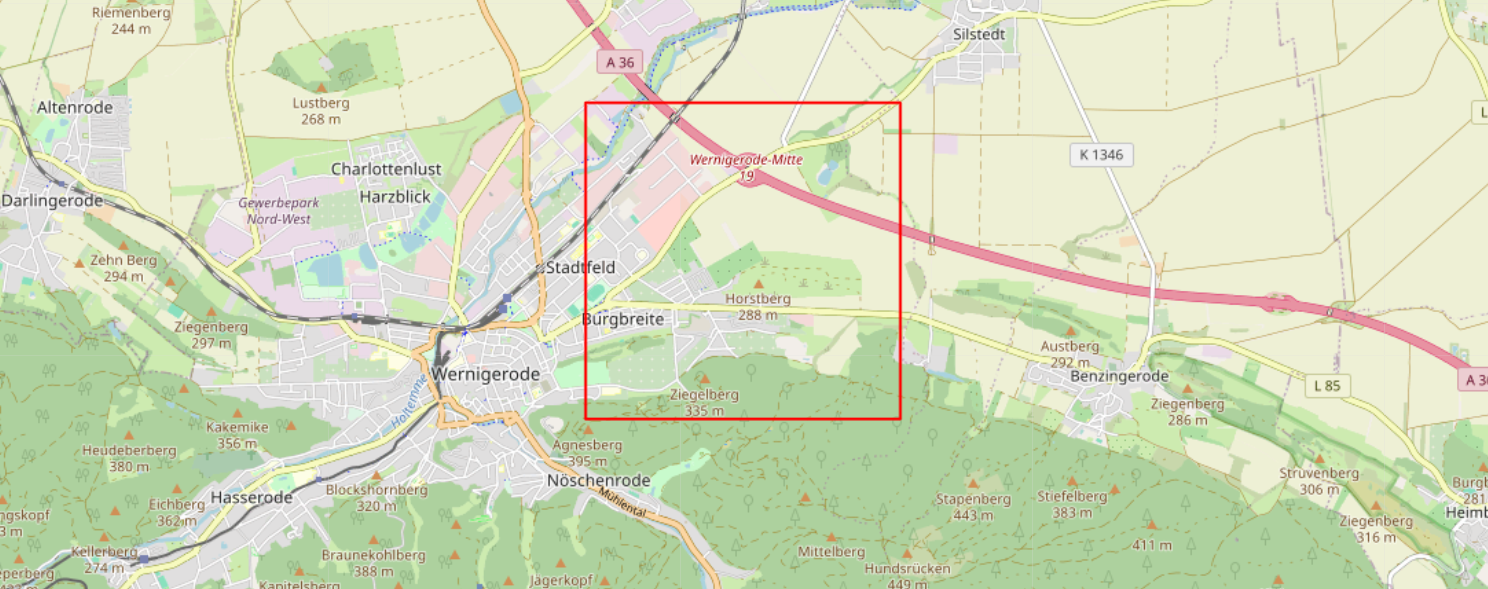